In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set paths
DRIVE_ZIP_PATH = "/content/drive/MyDrive/diabetic_retinography.zip"  # change if needed
WORK_DIR = "/content/diabetic_retinography"

import os
if os.path.exists(DRIVE_ZIP_PATH):
    print("Unpacking zip from Drive...")
    !rm -rf "{WORK_DIR}"
    !mkdir -p "{WORK_DIR}"
    !unzip -q "{DRIVE_ZIP_PATH}" -d "{WORK_DIR}"
    print("✅ Unzipped directly into:", WORK_DIR)
else:
    print("❌ Zip not found at DRIVE_ZIP_PATH.")
    if os.path.exists(WORK_DIR):
        print("Found existing folder:", WORK_DIR)
    else:
        print("Please upload dataset to Drive or Colab and update DRIVE_ZIP_PATH.")


Mounted at /content/drive
Unpacking zip from Drive...
✅ Unzipped directly into: /content/diabetic_retinography


In [2]:
# Chunk 2 — Install / imports and quick check
# (uncomment install lines only if you need extra packages)
# !pip install -q tensorflow

import os, glob, pandas as pd, numpy as np
WORK_DIR = "/content/diabetic_retinography"   # change if different
CSV_PATH = os.path.join(WORK_DIR, "train.csv")
IMG_ROOT = os.path.join(WORK_DIR, "colored_images")

assert os.path.exists(WORK_DIR), f"{WORK_DIR} not found. Update path."
assert os.path.exists(CSV_PATH), "train.csv not found in dataset root."
assert os.path.exists(IMG_ROOT), "colored_images folder not found."

df = pd.read_csv(CSV_PATH)
print("CSV rows:", len(df))
print("Image folders (example):", os.listdir(IMG_ROOT)[:10])
df.head()


CSV rows: 3662
Image folders (example): ['Proliferate_DR', 'Severe', 'Mild', 'Moderate', 'No_DR']


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
# Chunk 3 — map id_code -> filepath using folder names
import glob
def find_img_path(root, id_code):
    # match id_code.* anywhere under colored_images
    pats = glob.glob(os.path.join(root, "**", f"{id_code}.*"), recursive=True)
    return pats[0] if pats else None

# Add filepath column
df['filepath'] = df['id_code'].apply(lambda x: find_img_path(IMG_ROOT, x))
missing = df['filepath'].isna().sum()
print("Missing images:", missing)
df = df.dropna(subset=['filepath']).reset_index(drop=True)

# If you want to use folder names as labels instead of diagnosis numeric (optional)
# label_from_folder = { 'No_DR':0, 'Mild':1, 'Moderate':2, 'Severe':3, 'Proliferate_DR':4 }
# You said train.csv has diagnosis level; we'll use that numeric diagnosis for training.

df['diagnosis'] = df['diagnosis'].astype(int)
df.head()


Missing images: 0


,id_code,diagnosis,filepath
0,000c1434d8d7,2,/content/diabetic_retinography/colored_images/...
1,001639a390f0,4,/content/diabetic_retinography/colored_images/...
2,0024cdab0c1e,1,/content/diabetic_retinography/colored_images/...
3,002c21358ce6,0,/content/diabetic_retinography/colored_images/...
4,005b95c28852,0,/content/diabetic_retinography/colored_images/...


In [4]:
# Chunk 4 — tf.data pipeline
import tensorflow as tf
from sklearn.model_selection import train_test_split
SEED = 42
IMG_SIZE = (224,224)
BATCH = 32
NUM_CLASSES = 5

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=SEED)
print("Train:", len(train_df), "Val:", len(val_df))

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)   # 0-1
    img = tf.image.resize(img, IMG_SIZE)
    return img, tf.cast(label, tf.int32)

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
])

def make_ds(df_in, training=True):
    paths = df_in['filepath'].values
    labels = df_in['diagnosis'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=SEED)
    ds = ds.map(lambda p,l: preprocess(p,l), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_aug(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds = make_ds(val_df, training=False)


Train: 2929 Val: 733


In [5]:
# Chunk 5 — model training & save
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight

# class weights (helps imbalance)
labels = train_df['diagnosis'].values
cw = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=labels)
class_weights = {i: float(cw[i]) for i in range(NUM_CLASSES)}
print("Class weights:", class_weights)

# Model: EfficientNetB0 backbone + simple head
base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
base.trainable = False

inp = layers.Input(shape=(224,224,3))
x = base(inp, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='swish')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inp, out)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
cb = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

# 1) Train head
history1 = model.fit(train_ds, validation_data=val_ds, epochs=5, class_weight=class_weights, callbacks=cb)

# 2) Fine-tune last layers
base.trainable = True
for layer in base.layers[:-30]:   # freeze earlier layers, unfreeze last ~30
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(train_ds, validation_data=val_ds, epochs=12, initial_epoch=history1.epoch[-1]+1,
                     class_weight=class_weights, callbacks=cb)

# Final evaluate & save
loss, acc = model.evaluate(val_ds)
print(f"Val loss {loss:.4f}, val acc {acc:.4f}")
model.save("final_model.h5")
print("Saved best_model.h5 and final_model.h5")


Class weights: {0: 0.4056786703601108, 1: 1.979054054054054, 2: 0.7331664580725907, 3: 3.803896103896104, 4: 2.4822033898305085}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1885 - loss: 1.6857

92/92 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.1885 - loss: 1.6856 - val_accuracy: 0.1010 - val_loss: 1.6201 - learning_rate: 0.0010
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1751 - loss: 1.6144

92/92 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.1751 - loss: 1.6146 - val_accuracy: 0.4925 - val_loss: 1.5494 - learning_rate: 0.0010
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.2372 - loss: 1.6193 - val_accuracy: 0.1010 - val_loss: 1.6256 - learning_rate: 0.0010
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step - accuracy: 0.1681 - loss: 1.6445 - val_accuracy: 0.4925 - val_loss: 1.5889 - learning_rate: 0.0010
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.1919 - loss: 1.6082 - val_accuracy: 0.0805 - val_loss: 1.6856 - learning_rate: 5.0000e-04
Epoch 6/12
32/92 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - accuracy: 0.1844 - loss: 1.6585

KeyboardInterrupt: 

In [6]:
# --- MobileNetV2 training
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Build model
base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base.trainable = False  # freeze all layers

inp = layers.Input((224,224,3))
x = base(inp, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model_mobilenet = models.Model(inp, out)

# Compile
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.summary()

# Callbacks & class weights
cw = globals().get("class_weights", None)
cbs = [
    tf.keras.callbacks.ModelCheckpoint("best_mobilenet.h5", save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Train only for 6 epochs (no fine-tuning)
history = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    class_weight=cw,
    callbacks=cbs
)

# Save final model
model_mobilenet.save("mobilenet_final.h5")
print("✅ Training done — Saved mobilenet_final.h5 and best_mobilenet.h5")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,717 (9.26 MB)

 Trainable params: 167,173 (653.02 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

Epoch 1/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5242 - loss: 1.6607

92/92 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5250 - loss: 1.6594 - val_accuracy: 0.5430 - val_loss: 1.1112 - learning_rate: 0.0010
Epoch 2/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6434 - loss: 1.2646

92/92 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.6436 - loss: 1.2639 - val_accuracy: 0.5948 - val_loss: 0.9798 - learning_rate: 0.0010
Epoch 3/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6794 - loss: 1.0347

92/92 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.6795 - loss: 1.0348 - val_accuracy: 0.5880 - val_loss: 0.9572 - learning_rate: 0.0010
Epoch 4/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7022 - loss: 0.9793 - val_accuracy: 0.5580 - val_loss: 1.0715 - learning_rate: 0.0010
Epoch 5/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7119 - loss: 0.8702

92/92 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.7119 - loss: 0.8700 - val_accuracy: 0.6262 - val_loss: 0.9096 - learning_rate: 0.0010
Epoch 6/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7258 - loss: 0.8601 - val_accuracy: 0.5880 - val_loss: 1.0531 - learning_rate: 0.0010


✅ Training done — Saved mobilenet_final.h5 and best_mobilenet.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label index: 4
Predicted class: Proliferate_DR
  4: Proliferate_DR, prob = 0.6016
  3: Severe, prob = 0.3046
  1: Mild, prob = 0.0576
  2: Moderate, prob = 0.0362
  0: No_DR, prob = 0.0001


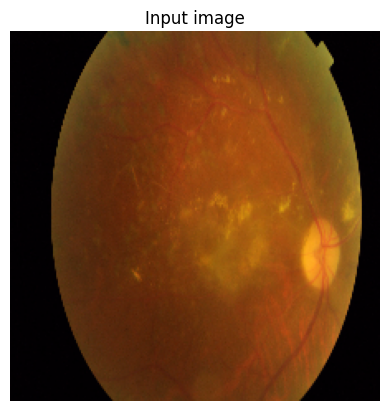

In [7]:
# --- Predict from a file path ---
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

MODEL_PATH = "/content/best_mobilenet.h5"   # or "best_mobilenet.h5"
IMAGE_PATH = "/content/diabetic_retinography/colored_images/Proliferate_DR/080ee76c958c.png"  # change to your image path

# label mapping (change if your labels differ)
label_map = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}

# load model
model = tf.keras.models.load_model(MODEL_PATH)

# preprocess helper
IMG_SIZE = (224, 224)
def load_and_preprocess(path):
    img = Image.open(path).convert("RGB")
    img = ImageOps.fit(img, IMG_SIZE, Image.BICUBIC)   # center-crop / resize preserving aspect
    arr = np.asarray(img).astype("float32") / 255.0    # 0-1
    return arr

img_arr = load_and_preprocess(IMAGE_PATH)
plt.imshow(img_arr); plt.axis('off'); plt.title("Input image")

# predict
probs = model.predict(np.expand_dims(img_arr, axis=0))[0]
pred_idx = int(np.argmax(probs))
print("Predicted label index:", pred_idx)
print("Predicted class:", label_map.get(pred_idx, "Unknown"))
# show probabilities (sorted)
for i in np.argsort(probs)[::-1]:
    print(f"  {i}: {label_map.get(i,'?')}, prob = {probs[i]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted label index: 3
Predicted class: Severe
  3: Severe, prob = 0.4259
  4: Proliferate_DR, prob = 0.3989
  2: Moderate, prob = 0.1646
  1: Mild, prob = 0.0106
  0: No_DR, prob = 0.0000


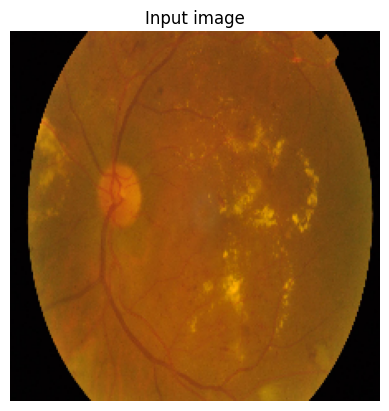

In [8]:
# --- Predict from a file path ---
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

MODEL_PATH = "/content/best_mobilenet.h5"   # or "best_mobilenet.h5"
IMAGE_PATH = "/content/diabetic_retinography/colored_images/Severe/0dc8d25b3f69.png"  # change to your image path

# label mapping (change if your labels differ)
label_map = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"}

# load model
model = tf.keras.models.load_model(MODEL_PATH)

# preprocess helper
IMG_SIZE = (224, 224)
def load_and_preprocess(path):
    img = Image.open(path).convert("RGB")
    img = ImageOps.fit(img, IMG_SIZE, Image.BICUBIC)   # center-crop / resize preserving aspect
    arr = np.asarray(img).astype("float32") / 255.0    # 0-1
    return arr

img_arr = load_and_preprocess(IMAGE_PATH)
plt.imshow(img_arr); plt.axis('off'); plt.title("Input image")

# predict
probs = model.predict(np.expand_dims(img_arr, axis=0))[0]
pred_idx = int(np.argmax(probs))
print("Predicted label index:", pred_idx)
print("Predicted class:", label_map.get(pred_idx, "Unknown"))
# show probabilities (sorted)
for i in np.argsort(probs)[::-1]:
    print(f"  {i}: {label_map.get(i,'?')}, prob = {probs[i]:.4f}")
